<a href="https://colab.research.google.com/github/EwoutH/Helsinki-flood-BEP-project/blob/main/road-graph/OSMnx_road_graph_analysis_BEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook 2 of 2, first part: https://colab.research.google.com/drive/1DE6MA7E2gOwGp7m35fzvrv5HQgdS3UQT

### Installation

Note that OSMnx is installed from my [own branch](https://github.com/EwoutH/osmnx/tree/edge-sum-refactor-2) with slight modification to the `travel_time` calculation. See [gboeing/osmnx#721](https://github.com/gboeing/osmnx/pull/721).

In [1]:
pip install -e git+https://github.com/EwoutH/osmnx.git@edge-sum-refactor-2#egg=OSMnx

Obtaining OSMnx from git+https://github.com/EwoutH/osmnx.git@edge-sum-refactor-2#egg=OSMnx
  Updating ./src/osmnx clone (to revision edge-sum-refactor-2)
  Running command git fetch -q --tags
  Running command git reset --hard -q b519b4bb178dce35c9197d227997e912b3ed401e
  Found existing installation: osmnx 1.1.1
    Can't uninstall 'osmnx'. No files were found to uninstall.
  Running setup.py develop for OSMnx


In [2]:
pip install ./src/osmnx

Processing ./src/osmnx
  Created wheel for osmnx: filename=osmnx-1.1.1-cp37-none-any.whl size=93657 sha256=52382caeb7dd8a1c7d0b42aa235dac0fc1bd3900be1a0724c6d90dacb2dcd6df
  Stored in directory: /tmp/pip-ephem-wheel-cache-fkiia015/wheels/43/a0/b3/5627d0ffe743765b2a32057b8ce416e7bc03a7e0f8560005b3
Successfully built osmnx
  Found existing installation: osmnx 1.1.1
    Can't uninstall 'osmnx'. No files were found to uninstall.


In [3]:
# Import packages
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
#import igraph as ig
import random

# Print versions
print(f'NetworkX version {nx.__version__}')
print(f'GeoPandas version {gpd.__version__}')
print(f'Pandas version {pd.__version__}')
print(f'NumPy version {np.__version__}')
print(f'OSMnx version {ox.__version__}')
#print(f'igraph version {ig.__version__}')

NetworkX version 2.5.1
GeoPandas version 0.9.0
Pandas version 1.1.5
NumPy version 1.19.5
OSMnx version 1.1.1


The following files are required:
* `road-graph-def.graphml`
* `TomTom-data-ext.csv`
* `TomTom-data-int.csv`
* `node-regions.csv`
* `edges-rain.csv`

Available on https://github.com/EwoutH/Helsinki-flood-BEP-project/tree/main/data

In [4]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir("drive/MyDrive/BEP Flood Resilience/Data")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Graph

In [5]:
# Load the MultiDiGraph and convert to DiGraph
ntypes = {'street_count': int, 'lon': float, 'lat': float, 'betw_cent': float}
etypes = {'min_lanes': int, 'oneway': bool, 'length': float, 'free_flow_speed': float,
          'free_flow_time': float, 'free_flow_capacity': int, 'edge_betw_cent': float}

G2b = ox.io.load_graphml('road-graph-def.graphml',edge_dtypes=etypes)
G2a = ox.utils_graph.get_digraph(G2b,weight='free_flow_time')

# Confirm network types
print(type(G2b))
print(type(G2a))

<class 'networkx.classes.multidigraph.MultiDiGraph'>
<class 'networkx.classes.digraph.DiGraph'>


In [6]:
# Load nodes and edges as GeoPandas Dataframes to be able to observe and plot them
nodes, edges = ox.graph_to_gdfs(G2b, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)
print(nodes["x"][5])

25498076.17910094


### Index and assign OD regions

In [7]:
# Some code to link each point to a region
noderegions = pd.read_csv('node-regions.csv', index_col=[0], skipinitialspace=True)
noderegions

,region,nodes,osmids,count
id,,,,
1,1,1254,2044,12
2,1,1373,784,12
3,1,1374,785,12
4,1,1375,1325,12
5,1,1376,1060,12
...,...,...,...,...
2583,199,1589,927,12
2584,199,1602,1896,12
2585,199,1719,1055,12


In [8]:
# Prepare the dataframe to be converted to a dictionary
noderegions2 = noderegions.set_index('osmids')
noderegions2 = noderegions2.drop(columns=['nodes', 'count'])
noderegions2.loc[noderegions2['region'] == 144]

,region
osmids,
0,144
140,144
1,144
142,144
112,144
113,144
1753,144
114,144
134,144


In [9]:
# Convert the Pandas dataframe to a dict
region_dict = noderegions2.to_dict('dict')['region']
print(region_dict)

{2044: 1, 784: 1, 785: 1, 1325: 1, 1060: 1, 786: 1, 1721: 1, 2100: 1, 2218: 1, 916: 1, 2045: 1, 935: 1, 484: 2, 485: 2, 954: 2, 920: 2, 921: 2, 1321: 2, 950: 2, 951: 2, 952: 2, 953: 2, 955: 2, 956: 2, 1485: 2, 1006: 3, 1007: 3, 1008: 3, 1010: 3, 1009: 3, 1011: 3, 1012: 3, 1030: 3, 1013: 3, 1014: 3, 1483: 3, 1029: 3, 1031: 3, 947: 4, 948: 4, 949: 4, 1001: 4, 998: 4, 999: 4, 1000: 4, 1002: 4, 1003: 4, 1924: 4, 1004: 4, 1005: 4, 793: 5, 342: 5, 735: 5, 1661: 5, 1654: 5, 346: 5, 782: 5, 883: 5, 842: 5, 733: 5, 734: 5, 1586: 5, 992: 6, 944: 6, 825: 6, 996: 6, 946: 6, 995: 6, 943: 6, 1834: 6, 990: 6, 991: 6, 993: 6, 997: 6, 341: 7, 1019: 7, 343: 7, 344: 7, 737: 7, 345: 7, 1662: 7, 736: 7, 739: 7, 738: 7, 2226: 7, 994: 7, 51: 8, 1282: 8, 1043: 8, 52: 8, 71: 8, 70: 8, 1016: 8, 867: 8, 1015: 8, 1042: 8, 1017: 8, 1018: 8, 49: 9, 1040: 9, 67: 9, 727: 9, 1039: 9, 90: 9, 709: 9, 717: 9, 718: 9, 1037: 9, 1038: 9, 1630: 9, 6: 10, 7: 10, 2482: 10, 46: 10, 1786: 10, 1025: 10, 779: 10, 2445: 10, 1024: 1

In [10]:
# Add region as a node attribute
nx.set_node_attributes(G2a, region_dict, 'region')
assert G2a.nodes[0]['region'] == 144

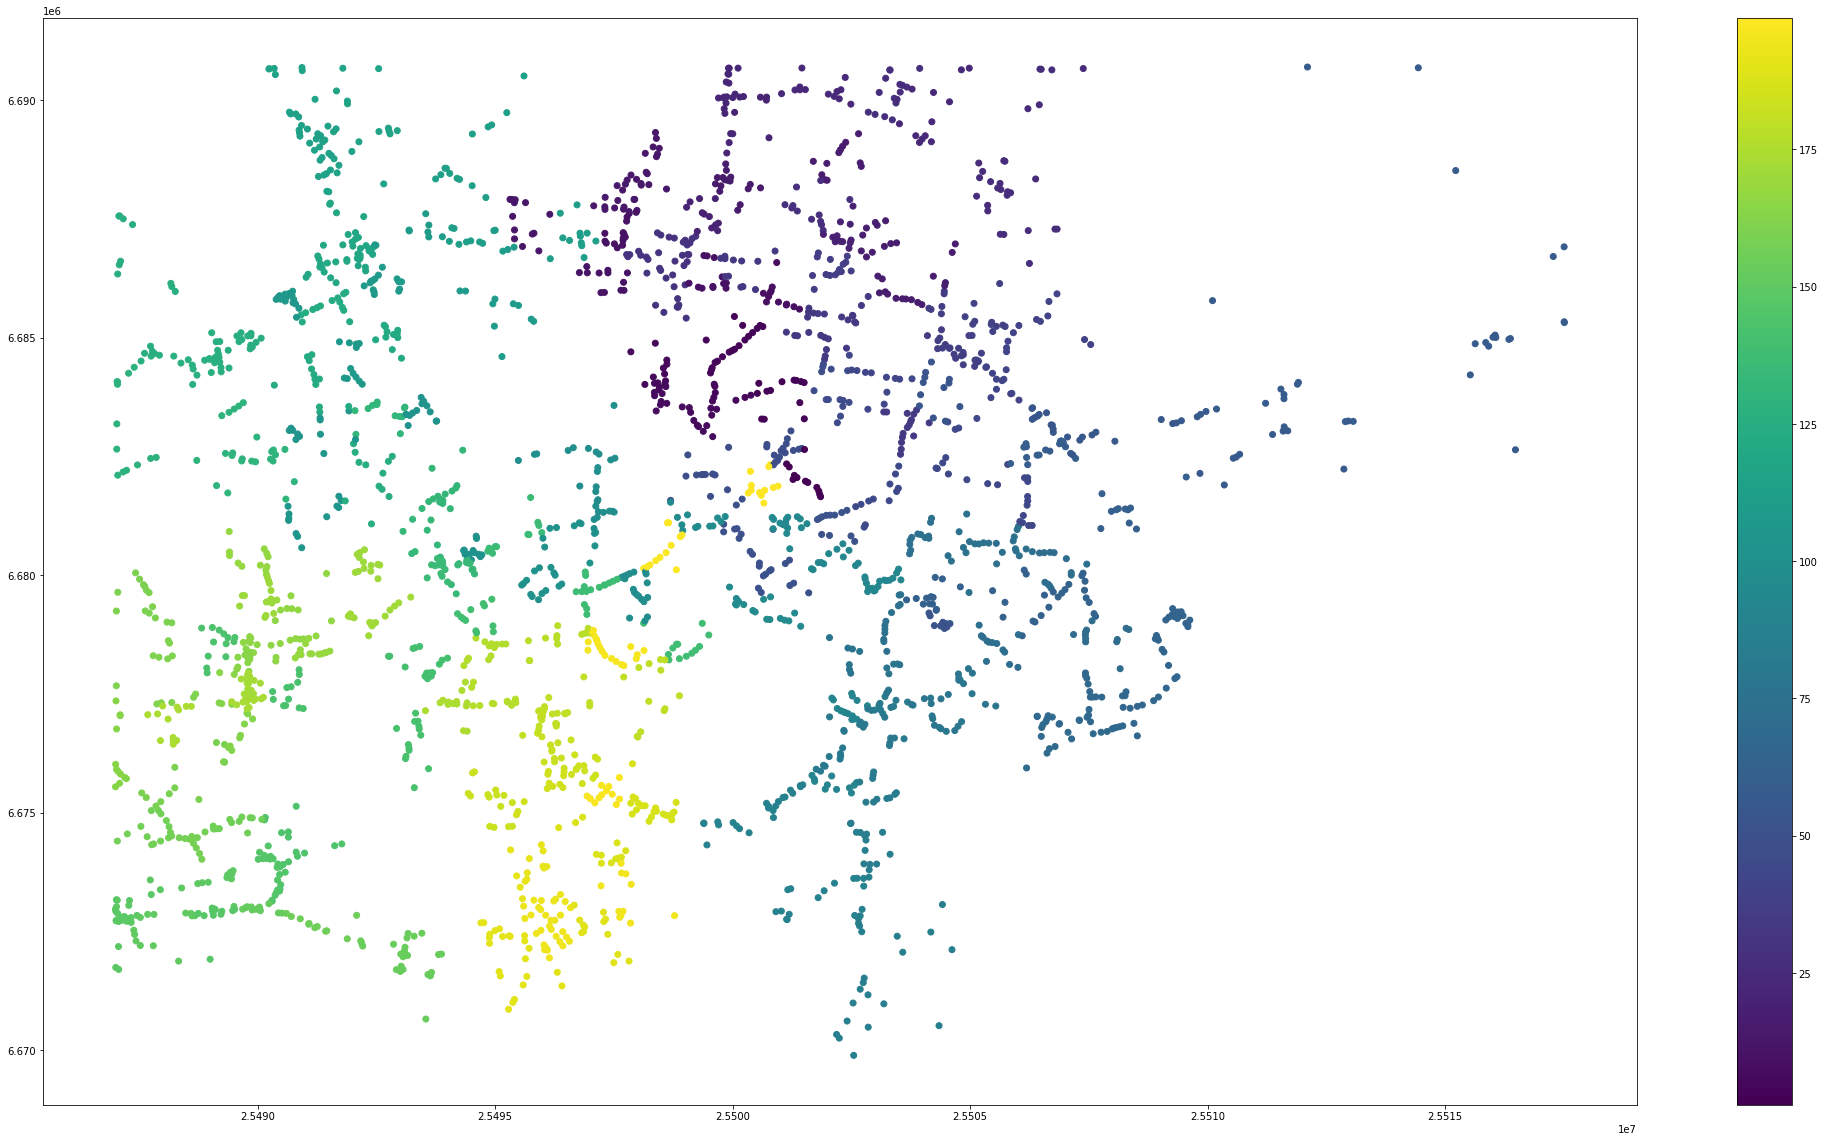

In [11]:
# Graph to see if clusting is correct
nodes2 = ox.graph_to_gdfs(G2a, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)
ax = nodes2.plot(column='region', figsize=(36,20), legend=True)

In [12]:
# Now the same steps for the count
nodecounts = noderegions.set_index('osmids')
nodecounts = nodecounts.drop(columns=['nodes', 'region'])

In [13]:
# Convert the Pandas dataframe to a dict
count_dict = nodecounts.to_dict('dict')['count']
print(count_dict)

{2044: 12, 784: 12, 785: 12, 1325: 12, 1060: 12, 786: 12, 1721: 12, 2100: 12, 2218: 12, 916: 12, 2045: 12, 935: 12, 484: 13, 485: 13, 954: 13, 920: 13, 921: 13, 1321: 13, 950: 13, 951: 13, 952: 13, 953: 13, 955: 13, 956: 13, 1485: 13, 1006: 13, 1007: 13, 1008: 13, 1010: 13, 1009: 13, 1011: 13, 1012: 13, 1030: 13, 1013: 13, 1014: 13, 1483: 13, 1029: 13, 1031: 13, 947: 12, 948: 12, 949: 12, 1001: 12, 998: 12, 999: 12, 1000: 12, 1002: 12, 1003: 12, 1924: 12, 1004: 12, 1005: 12, 793: 12, 342: 12, 735: 12, 1661: 12, 1654: 12, 346: 12, 782: 12, 883: 12, 842: 12, 733: 12, 734: 12, 1586: 12, 992: 12, 944: 12, 825: 12, 996: 12, 946: 12, 995: 12, 943: 12, 1834: 12, 990: 12, 991: 12, 993: 12, 997: 12, 341: 12, 1019: 12, 343: 12, 344: 12, 737: 12, 345: 12, 1662: 12, 736: 12, 739: 12, 738: 12, 2226: 12, 994: 12, 51: 12, 1282: 12, 1043: 12, 52: 12, 71: 12, 70: 12, 1016: 12, 867: 12, 1015: 12, 1042: 12, 1017: 12, 1018: 12, 49: 12, 1040: 12, 67: 12, 727: 12, 1039: 12, 90: 12, 709: 12, 717: 12, 718: 12

In [14]:
# Add count as a node attribute
nx.set_node_attributes(G2a, count_dict, 'count')
assert G2a.nodes[0]['count'] == 13

In [15]:
# Prepare the dataframe and convert to a dictionary
regioncounts = noderegions.set_index('region')
regioncounts = regioncounts.drop(columns=['nodes', 'osmids'])
region_counts = regioncounts.to_dict('dict')['count']
print(region_counts)
assert region_counts[144] == 13

{1: 12, 2: 13, 3: 13, 4: 12, 5: 12, 6: 12, 7: 12, 8: 12, 9: 12, 10: 15, 11: 12, 12: 13, 13: 15, 14: 16, 15: 16, 16: 12, 17: 15, 18: 12, 19: 13, 20: 12, 21: 12, 22: 15, 23: 13, 24: 12, 25: 12, 26: 16, 27: 16, 28: 12, 29: 14, 30: 12, 31: 12, 32: 12, 33: 13, 34: 12, 35: 16, 36: 12, 37: 15, 38: 16, 39: 13, 40: 12, 41: 12, 42: 12, 43: 12, 44: 12, 45: 12, 46: 14, 47: 16, 48: 12, 49: 12, 50: 12, 51: 12, 52: 12, 53: 12, 54: 12, 55: 12, 56: 12, 57: 16, 58: 12, 59: 16, 60: 12, 61: 12, 62: 12, 63: 12, 64: 13, 65: 12, 66: 12, 67: 12, 68: 12, 69: 15, 70: 12, 71: 12, 72: 13, 73: 12, 74: 12, 75: 12, 76: 12, 77: 14, 78: 12, 79: 13, 80: 12, 81: 12, 82: 12, 83: 12, 84: 12, 85: 12, 86: 12, 87: 12, 88: 14, 89: 12, 90: 12, 91: 15, 92: 16, 93: 13, 94: 16, 95: 17, 96: 12, 97: 19, 98: 14, 99: 13, 100: 14, 101: 12, 102: 12, 103: 13, 104: 12, 105: 12, 106: 16, 107: 12, 108: 12, 109: 12, 110: 12, 111: 12, 112: 12, 113: 13, 114: 17, 115: 13, 116: 12, 117: 12, 118: 16, 119: 12, 120: 13, 121: 12, 122: 12, 123: 13, 

In [16]:
# Benchmarks
import timeit

print(timeit.timeit(lambda: G2a.nodes[5]['region'], number=10000))
print(timeit.timeit(lambda: region_dict[5], number=10000))

print(timeit.timeit(lambda: G2a.nodes[0]['count'], number=10000))
print(timeit.timeit(lambda: region_counts[144], number=10000))

0.011689666000165744
0.0020699550000244926
0.015554656999938743
0.0012107090001336474


### OD data

In [17]:
# Import of TomTom OD data as MultiIndexed 
tte = pd.read_csv('TomTom-data-ext.csv', index_col=[0,1], skipinitialspace=True)
tti = pd.read_csv('TomTom-data-int.csv', index_col=[0,1], skipinitialspace=True)

In [18]:
tte

All  Night  Day  Evening
Origin Destination                          
1      1            116      1  109       13
       2             54      2   38        0
       3              4      1    4        0
       4             13      0   11        2
       5             15      0   13        0
...                 ...    ...  ...      ...
199    195           47      2   32        1
       196           64      1   45        0
       197           71     10   51        0
       198           96      4   70        0
       199          431     50  313       44

[39601 rows x 4 columns]

In [19]:
# Print some validation
print(tte.loc[(1, 1), "All"])
print(tte.at[(1, 1), "All"])
print(tte._get_value(0, 0, "All"))

# Small benchmark
print(timeit.timeit(lambda: tte.loc[(1, 1), "All"], number=10000))
print(timeit.timeit(lambda: tte.at[(1, 1), "All"], number=10000))
print(timeit.timeit(lambda: tte._get_value(1-1, 1-1, "All"), number=10000))

116
116
116
2.2310629660000814
0.1773753620000207
0.19342316400002346


### Add rain depths to edges

In [20]:
# Add rain depth stats (max, mean, length) for edges
edgesrain = pd.read_csv('edges-rain.csv', index_col=[1,2,3], skipinitialspace=True)
edgesrain = edgesrain.fillna(0)
print(edgesrain)

               OID_  ... ZLength198mm
u    v    key        ...             
0    140  0       1  ...     0.000000
     1    0       2  ...     0.000000
140  143  0       3  ...   189.905234
     2470 0       4  ...     9.753023
     134  0       5  ...     0.000000
...             ...  ...          ...
2565 2566 0    5505  ...     0.000000
2579 792  0    5506  ...   110.702920
2584 2583 0    5507  ...     0.000000
     2585 0    5508  ...     0.000000
2585 1781 0    5509  ...     0.000000

[5509 rows x 21 columns]


Possible speed formulas:
 - `85*e^(-9x)` (x depth in meters) ([Choo et al., 2020](https://www.mdpi.com/2073-4441/12/4/926))
 - `0.0009w^2-0.5529w+86.9448` (w depth in millimeters) ([Pregnalato et al., 2017](https://www.sciencedirect.com/science/article/pii/S1361920916308367))

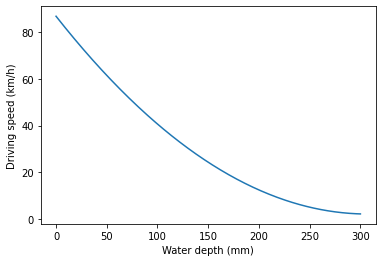

In [21]:
import matplotlib.pyplot as plt
xp = np.array(range(0, 301))
yp = 0.0009*xp**2-0.5529*xp+86.9448
plt.plot(xp, yp)
plt.xlabel('Water depth (mm)')
plt.ylabel('Driving speed (km/h)')
plt.show()

### The functions

In [22]:
import itertools
import gc
from collections import defaultdict

In [23]:
def speed_function(wd, formula='Pregnalato'):
  if formula == 'Pregnalato':
    wd = wd * 1000
    return 0.0009*wd**2-0.5529*wd+86.9448
  elif formula == 'Choo':
    return 85*wd**(-9*wd)
  else:
    print('Unknow depth-speed formula. Implemented: "Pregnalato", "Choo".')

In [24]:
def prepare_graph(graph, drivable_depth=0.30, rain=[44, 54, 71, 86, 20, 198]):
  # Convert the DiGraph to MultiDiGraph (for OSMnx)
  if type(graph) is nx.classes.digraph.DiGraph:
    graph = nx.MultiDiGraph(graph)
  elif type(graph) is not nx.classes.multidigraph.MultiDiGraph:
    print('Unsupported graph type. Input NetworkX DiGraph or MultiDiGraph.')

  # Save the nodes and edges as GeoPandas DataFrame
  nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False, node_geometry=True, fill_edge_geometry=True)

  ed = {}      # Empty dict for edges
  for i in rain:
    # Save the edges as GeoPandas DataFrame
    ed[str(i)] = ox.graph_to_gdfs(graph, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)

    # Add flood levels to edges dataframe
    ed[str(i)] = pd.concat([ed[str(i)], edgesrain.filter(regex=f'{rain}mm')], axis=1)

    # Select edges which are drivable
    ed[str(i)] = ed[str(i)][ed[str(i)][f'ZMax{i}mm'] <= drivable_depth]

    # Calculate reduced speeds
    # reduced_speed = flood_lengt/lengt * max(flooded_speed,normal_speed) + (1-flood_lengt/lengt) * normal_speed
    ed[str(i)]['reduced_speed'] = ed[str(i)][f'ZLength{i}mm'] / ed[str(i)]['length'] \
    * pd.concat([speed_function(ed[str(i)][f'ZMean{i}mm']), ed[str(i)]['free_flow_speed']], axis=1).min(axis=1) \
    + (1 - ed[str(i)][f'ZLength{i}mm'] / ed[str(i)]['length']) * ed[str(i)]['free_flow_speed']

  gm_dict = {} # Empty dict for MultiDiGraphs
  gb_dict = {} # Empty dict for DiGraphs

  # Create graphs from edge dictionaries
  for k,v in ed.items():
    gm_dict[k] = ox.utils_graph.graph_from_gdfs(nodes, v)
    gb_dict[k] = ox.utils_graph.get_digraph(gm_dict[k], weight='free_flow_time')

  return gb_dict

In [25]:
def analyse_graph(graph):
  # Calcualte the paths lengths of all reachable pairs
  reachable_path_lengths = dict(nx.all_pairs_dijkstra_path_length(graph, cutoff=None, weight="free_flow_time"))

  # Create empty dictionaries
  od_weights = {}         # The length and OD weight for each trip
  od_weights_region = {}  # The OD weights between each region. For validation.

  for origin,d in reachable_path_lengths.items():
    ro = region_dict[origin]
    for destination, length in d.items():
      rd = region_dict[destination]
      trips = tte.at[(ro, rd), "All"]
      weight = trips / (region_counts[ro]*region_counts[rd])

      od_weights[(origin,destination)] = (length, weight) 
      #od_weights_region[(ro,rd)] = od_weights_region.get((ro,rd), 0) + weight

  # Calculate some stats
  number_nodes = graph.number_of_nodes()             # Number of nodes in the graph
  trip_count = tte["All"].sum()                     # Sum of all trips in the OD-matrix
  total_travel_time = sum([i[0]*i[1] for i in od_weights.values()])      # Total weighted travel time (s)
  route_count = len(od_weights)                     # All possible routes between nodes
  possible_weight = sum([i[1] for i in od_weights.values()])
  mean_travel_time = total_travel_time / possible_weight

  print(f'{possible_weight:.1f} trips on {route_count} routes took {total_travel_time:.1f} seconds, {mean_travel_time:.3f} s on average')
  print(f'{number_nodes**2} possible node combinations, {route_count} available paths and {number_nodes**2-route_count} not available ({(route_count/number_nodes**2)*100:.3f}%)')

  # Calculate OD weights for impossible routes
  node_combinations = list(itertools.product(range(graph.number_of_nodes()), repeat=2))
  possible_combinations = list(od_weights)    # list(dict) takes only the keys
  impossible_combinations = list(set(node_combinations) - set(possible_combinations))
  isolated_nodes = nx.number_of_isolates(graph)

  impossible_paths = {}
  for o,d in impossible_combinations:
    ro = region_dict[o]
    rd = region_dict[d]
    trips = tte.at[(ro, rd), "All"]
    weight = trips / (region_counts[ro]*region_counts[rd])
    impossible_paths[(o,d)] = weight
  
  # Stats
  impossible_weight = sum(impossible_paths.values())

  print(f'Weight of possible trips: {possible_weight:.2f}, weight of impossible trips: {impossible_weight:.2f}, percentage impossible: {impossible_weight/(possible_weight+impossible_weight)*100:.3f}%')
  print(f'Isolated nodes: {isolated_nodes}, percentage: {100*isolated_nodes/number_nodes:.2f}%\n')

  return_dict = {
      'mean_travel_time': mean_travel_time,
      'stats': [possible_weight, total_travel_time, mean_travel_time, route_count, number_nodes**2-route_count, impossible_weight, trip_count, number_nodes, isolated_nodes]
      'impossible_paths': impossible_paths,
      'od_weights': od_weights,
      #'od_weights_region': od_weights_region
  }

  return return_dict

In [26]:
def od_centrality(graph,  stats):
  # Convert the DiGraph to MultiDiGraph (for OSMnx)
  if type(graph) is nx.classes.digraph.DiGraph:
    graph = nx.MultiDiGraph(graph)
  elif type(graph) is not nx.classes.multidigraph.MultiDiGraph:
    print('Unsupported graph type. Input NetworkX DiGraph or MultiDiGraph.')

  # Save the nodes and edges as GeoPandas DataFrame
  nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

  paths = dict(nx.all_pairs_dijkstra_path(graph, cutoff=None, weight="free_flow_time"))

  # Get all possible paths in a tuple-keyed dictionary
  combis = {}
  for origin,d in paths.items():
    for destination, path in d.items():
      combis[(origin, destination)] = path
  
  # Calculated the OD-weighted centrality
  weighted_centrality_dict = defaultdict(float)
  for od, path in combis.items():
    od_weight = stats["od_weights"][od][1] # [1] selects the weight in the tuple
    for edge in list(zip(path, path[1:], np.zeros((len(path)), dtype=int))):
      weighted_centrality_dict[edge] += od_weight

  # Add OD centrality values to edges dataframe
  edges["weighted_centrality"] = pd.Series(weighted_centrality_dict)
  edges["weighted_centrality"].fillna(0)

  # Generate new NetworkX MultiDiGraph from nodes and edges and convert to DiGraph
  graph_m = ox.utils_graph.graph_from_gdfs(nodes, edges)
  graph_d = ox.utils_graph.get_digraph(graph_m, weight='free_flow_time')
  return graph_d

### Comparing scenarios

 - Average travel time increase [s/s = %] for identical set of routes
 - Routes with their weights [{dict}] not possible, as percentage of all [n/n = %]
 - Impact of removing individual edges and their effect on total travel time
 - Removing combinations of individual edges and measuring their impact on total travel time. selection on highest travel time impact or centrality

In [27]:
default_stats = analyse_graph(G2a)

1911281.3 trips on 6505175 routes took 939415372.5 seconds, 491.511 s on average
6692569 possible node combinations, 6505175 available paths and 187394 not available (97.200%)
Weight of possible trips: 1911281.25, weight of impossible trips: 137566.75, percentage impossible: 6.714%
Isolated nodes: 0, percentage: 0.00%



In [28]:
rain = [44, 54, 71, 86, 20, 198]

flooded_graphs = prepare_graph(G2a, drivable_depth=0.30, rain=rain)
flooded_stats = {}
for i in rain:
  print(f'### Stats for {i} mm rain ###')
  flooded_stats[str(i)] = analyse_graph(flooded_graphs[str(i)])
  flooded_graphs[str(i)] = od_centrality(flooded_graphs[str(i)], flooded_stats[str(i)])
  gc.collect()

### Stats for 44 mm rain ###
1630934.1 trips on 5102003 routes took 1156111379.6 seconds, 708.865 s on average
6692569 possible node combinations, 5102003 available paths and 1590566 not available (76.234%)
Weight of possible trips: 1630934.08, weight of impossible trips: 417913.92, percentage impossible: 20.398%
Isolated nodes: 46, percentage: 1.78%

### Stats for 54 mm rain ###
1595542.2 trips on 4873833 routes took 1392150015.4 seconds, 872.525 s on average
6692569 possible node combinations, 4873833 available paths and 1818736 not available (72.825%)
Weight of possible trips: 1595542.23, weight of impossible trips: 453305.77, percentage impossible: 22.125%
Isolated nodes: 54, percentage: 2.09%

### Stats for 71 mm rain ###
1582734.3 trips on 4807291 routes took 1393595768.6 seconds, 880.499 s on average
6692569 possible node combinations, 4807291 available paths and 1885278 not available (71.830%)
Weight of possible trips: 1582734.34, weight of impossible trips: 466113.66, percenta

In [80]:
G3a = od_centrality(G2a, default_stats)
gc.collect()

0

In [81]:
# Be able to iterate through rain values including 0
rain = [0, 44, 54, 71, 86, 20, 198]
flooded_graphs[str(0)] = G3a

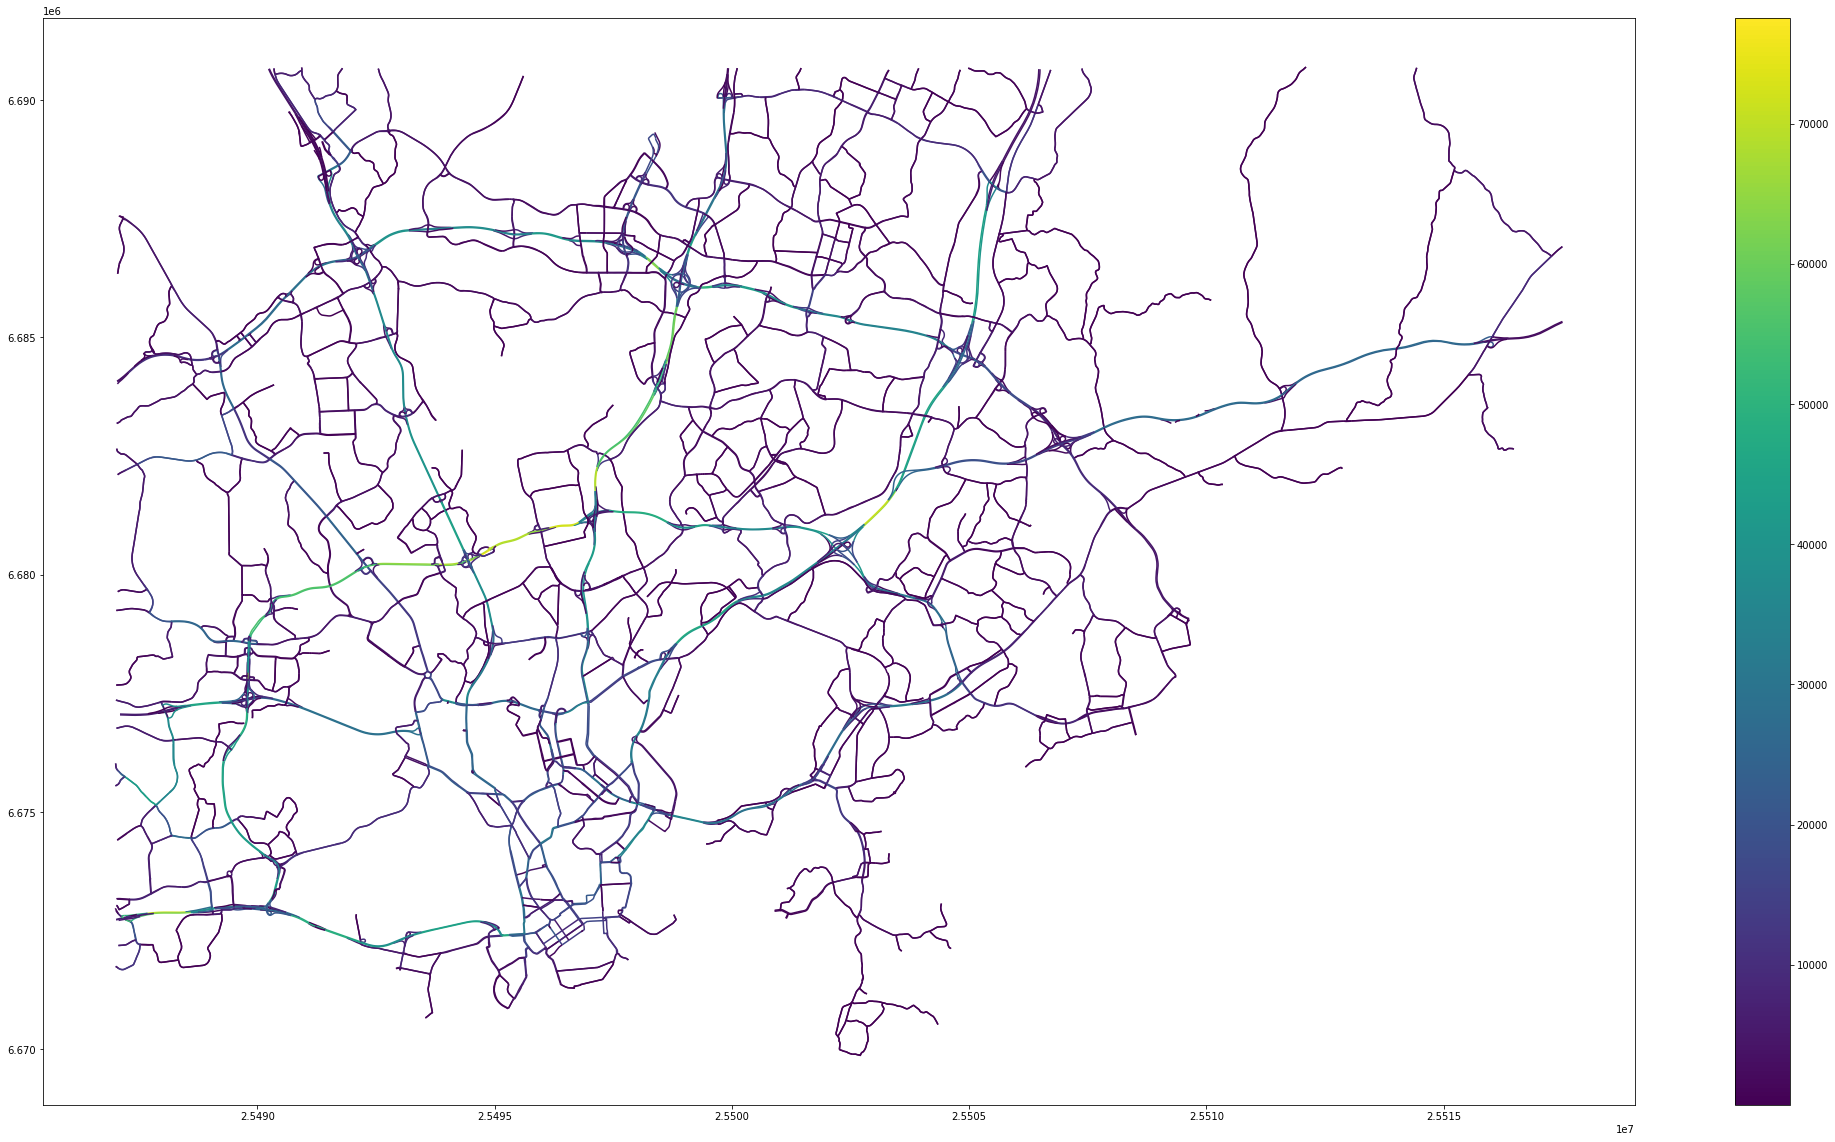

In [82]:
# Plot the betweenness centrality of the edges
G3b = nx.MultiDiGraph(G3a)
edges = ox.graph_to_gdfs(G3b, nodes=False, edges=True, node_geometry=True, fill_edge_geometry=True)
ax = edges.plot(column="weighted_centrality", figsize=(36,20), legend=True)

### Mean travel time comparison

In [83]:
# Compares the mean travel time between identical sets of routes
def compare_travel_time(stats, rain, stats_def=default_stats):
  # Calculate the total travel time for routes in both graphs (lengths * weights)
  def_tt = sum([j[0]*j[1] for i,j in stats_def["od_weights"].items() if i in stats["od_weights"].keys()])

  # Calculate the weight for routes in both graphs (weights)
  def_w = sum([j[1] for i,j in stats_def["od_weights"].items() if i in stats["od_weights"].keys()])

  # Calculate the mean travel time
  def_mean_tt = def_tt / def_w

  # Print the output
  print(f'Mean travel time on identical set of routes: {def_mean_tt:.3f} s, with {rain}mm rain: {stats["mean_travel_time"]:.3f}')

In [84]:
print(f'Mean travel time with all routes: {default_stats["mean_travel_time"]:.3f} s')
for i in rain[1:]:
  compare_travel_time(flooded_stats[str(i)], i)

Mean travel time with all routes: 491.511 s
Mean travel time on identical set of routes: 486.333 s, with 44mm rain: 708.865
Mean travel time on identical set of routes: 486.142 s, with 54mm rain: 872.525
Mean travel time on identical set of routes: 486.163 s, with 71mm rain: 880.499
Mean travel time on identical set of routes: 486.292 s, with 86mm rain: 1065.576
Mean travel time on identical set of routes: 488.838 s, with 20mm rain: 613.894
Mean travel time on identical set of routes: 486.419 s, with 198mm rain: 1084.374


### OD-weighted centrality comparison

In [109]:
def compare_od_centrality(n=10, rain=rain):
  od_dict = {}
  high_centrality = []
  edge_data = {}
  for j in rain:
    # Get weighted centrality edges values in a dictionary
    od_dict[str(j)] = nx.get_edge_attributes(flooded_graphs[str(j)], "weighted_centrality")

    # Create a list with the n highest weighted_centrality values for each rain value
    high = sorted(od_dict[str(j)], key=od_dict[str(j)].get, reverse=True)[:n]
    for edge in high:
        if edge not in high_centrality:
            high_centrality.append(edge)

    # Get all the edge weighted centrality values into a dictionary
    edge_data[j] = flooded_graphs[str(j)].edges

  # Add the weighted centrality values for determined list of edges to dictionaries
  od_cent = {}
  for i in high_centrality:
    od_cent[str(i)] = [edge_data[j][i]["weighted_centrality"] if i in edge_data[j].keys() else 0.0 for j in rain]

  # Return and PandasDataframe with the OD-centrality values for each edge and rain value
  return pd.DataFrame.from_dict(od_cent, orient='index', columns=rain)

In [110]:
compare_od_centrality(5)

,0,44,54,71,86,20,198
"(1459, 1464)",77572.319179,40.187500,5.270833,5.270833,5.270833,50509.301315,2.597222
"(1794, 131)",72298.196821,17319.634751,27295.886850,27201.838794,27968.770428,45990.503691,16.582400
"(589, 2251)",72268.253426,7.685516,7.685516,7.685516,7.685516,22700.179885,0.000000
"(21, 20)",72065.376740,11134.186734,23192.880612,23125.912029,24711.674664,63589.863618,1747.428166
"(549, 550)",71457.243710,100511.834344,69273.454583,69149.585188,68482.002056,69955.539310,64423.182919
"(1706, 1705)",21136.195328,153855.136770,192996.442078,187868.327220,190688.007517,124040.841803,179687.132448
"(1705, 1704)",16595.572653,150158.227681,189617.099591,184538.264196,186597.445146,121554.429884,175704.640589
"(836, 1779)",13194.741362,105007.376129,133754.339483,129586.490071,17344.089755,72732.640425,16992.784467
"(894, 836)",9871.942402,104897.443129,133604.216885,129423.521426,16364.362233,69425.328911,16023.018430
"(1779, 1926)",2043.386110,104118.163394,133064.331694,128949.481428,21050.506308,69750.815569,20634.488326
